In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk.tokenize import word_tokenize#RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
import pickle

[nltk_data] Downloading package stopwords to C:\Users\Carlos
[nltk_data]     Cocuy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Carlos
[nltk_data]     Cocuy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Carlos
[nltk_data]     Cocuy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df= pd.read_csv("Wos.csv" ,encoding= 'latin_1')

df.head()

,Posting Date,No.,Equipment Object,Owner,Sell-To Customer No.,Mx Contract,Fleet,Make,Model,Serial No.,...,DAMAGE,REQUEST,ATTACH,BILL TO,PMs,DT,Days Down,CAT,WC,FLS GRP
0,6/4/2008,S987401,40306,Sold,22400-0002,NaN,NaN,NaN,7FBCU25,7FBCU25-61708,...,$331.76,NaN,NaN,CUST,NaN,2.4,0.04,DAMAGE,UMATILLA,FORKLIFTS
1,6/17/2008,WO-001129,62016,Sold,22400-0001,MC000725,NaN,NaN,7FBCU32,7FBCU32-63266,...,NaN,NaN,NaN,CUST,NaN,2.0,0.08,PM,3174,FORKLIFTS
2,6/17/2008,WO-001128,62017,Sold,22400-0001,MC000725,NaN,NaN,7FBCU32,7FBCU32-63273,...,NaN,NaN,NaN,CUST,NaN,NaN,0.08,PM,3174,FORKLIFTS
3,6/17/2008,WO-001125,62025,Sold,22400-0001,MC000725,NaN,NaN,7FBCU32,7FBCU32-63288,...,NaN,NaN,NaN,CUST,NaN,2.0,0.08,PM,5520,FORKLIFTS
4,6/17/2008,WO-001127,62026,Sold,22400-0001,MC000725,NaN,NaN,7FBCU32,7FBCU32-63297,...,NaN,NaN,NaN,CUST,NaN,2.0,0.08,PM,3174,FORKLIFTS


In [3]:
df.columns
df_short = df[  ['Service Description', 'CAT', 'WC', 'FLS GRP']]
df_short = df_short[df_short['FLS GRP'] == 'FORKLIFTS']
df_short.head()

df_short.shape

(12397, 4)

In [4]:
df_short['Service Description'] = df_short['Service Description'].str.replace("\r\n" , "")
df_short['Service Description'] = df_short['Service Description'].str.replace("\n" , "")
df_short['Service Description'] = df_short['Service Description'].str.replace("\r" , "")
df_short['Service Description'] = df_short['Service Description'].str.lower()

In [5]:


def Search_desc(X):
 if re.search("svc desc:|sdesc:", str(X) ) == None:
    startLoc = 0
    return ""
 else:
    startLoc = re.search("svc desc:|sdesc:", str(X) ).end()
 if re.search("complaint:|cause:|cure:|additional:" , str(X) ) == None:
    endLoc = len(X)
 else:
    endLoc = re.search("complaint:|cause:|cure:|additional:" , str(X) ).start()  
 return X[startLoc : endLoc]



def Search_comp(X):
 if re.search("complaint:", str(X) ) == None:
    startLoc = 0
    return ""
 else:
    startLoc = re.search("complaint:", str(X) ).end()
 if re.search("cause:|cure:|additional:" , str(X) ) == None:
    endLoc = len(X)
 else:
    endLoc = re.search("cause:|cure:|additional:" , str(X) ).start()  
 return X[startLoc : endLoc]



def Search_cause(X):
 if re.search("cause:", str(X) ) == None:
    startLoc = 0
    return ""
 else:
    startLoc = re.search("cause:", str(X) ).end()
 if re.search("cure:|additional:" , str(X) ) == None:
    endLoc = len(X)
 else:
    endLoc = re.search("cure:|additional:" , str(X) ).start()  
 return X[startLoc : endLoc]



def Search_cure(X):
 if re.search("cure:", str(X) ) == None:
    startLoc = 0
    return ""
 else:
    startLoc = re.search("cure:", str(X) ).end()
 if re.search("additional:" , str(X) ) == None:
    endLoc = len(X)
 else:
    endLoc = re.search("additional:" , str(X) ).start()  
 return X[startLoc : endLoc]

def Search_additional(X):
 if re.search("additional:", str(X) ) == None:
    startLoc = 0
    endLoc = 0
 else:
    startLoc = re.search("additional:", str(X) ).end()
    endLoc = len(str(X))
 return X[startLoc : endLoc]


In [6]:
df_short['Service Description'] = df_short['Service Description'].astype(str)

In [7]:
df_short['desc'] = df_short['Service Description'].apply(lambda x: Search_desc(x))
df_short['Complaint'] = df_short['Service Description'].apply(lambda x: Search_comp(x))
df_short['Cause'] = df_short['Service Description'].apply(lambda x: Search_cause(x))
df_short['Cure'] = df_short['Service Description'].apply(lambda x: Search_cure(x))
df_short['Additioanl'] = df_short['Service Description'].apply(lambda x: Search_additional(x))

df_short.head(10)

,Service Description,CAT,WC,FLS GRP,desc,Complaint,Cause,Cure,Additioanl
0,svc desc: field servicecomplaint: safety issue...,DAMAGE,UMATILLA,FORKLIFTS,field service,safety issues lights,travel alarm strobe,replace part replace part,back-up alarm needs installation & serial # 6...
1,svc desc: pm agreementsadditional: planned mai...,PM,3174,FORKLIFTS,pm agreements,,,,planned maintenance
2,svc desc: pm agreementscause: planned maintenance,PM,3174,FORKLIFTS,pm agreements,,planned maintenance,,
3,svc desc: pm agreements planned maintenance la...,PM,5520,FORKLIFTS,pm agreements planned maintenance labor not b...,,,,
4,svc desc: pm agreements planned maintenance,PM,3174,FORKLIFTS,pm agreements planned maintenance,,,,
5,svc desc: pm agreements planned maintenance,PM,UMATILLA,FORKLIFTS,pm agreements planned maintenance,,,,
6,svc desc: field service contactor not opening ...,REPAIR,UMATILLA,FORKLIFTS,field service contactor not opening all the w...,,,,
7,svc desc: field service unit runs continuously...,REPAIR,UMATILLA,FORKLIFTS,field service unit runs continuously to custo...,,,,
8,svc desc: service department policycomplaint: ...,REPAIR,3174,FORKLIFTS,service department policy,lights,burnt bulb,replace part,lights / left front worklight evaluate light ...
9,svc desc: replace seatcomplaint: generalcause:...,DAMAGE,5520,FORKLIFTS,replace seat,general,seat broken,replace part,seat broken evaluate seat ordered new seat 06...


In [8]:

df_short['desc'] = df_short['desc'].str.strip()
df_short['Complaint'] = df_short['Complaint'].str.strip()
df_short['Cause'] = df_short['Cause'].str.strip()
df_short['Cure'] = df_short['Cure'].str.strip()
df_short['Additioanl'] = df_short['Additioanl'].str.strip()


In [9]:
df_short.head(10)

,Service Description,CAT,WC,FLS GRP,desc,Complaint,Cause,Cure,Additioanl
0,svc desc: field servicecomplaint: safety issue...,DAMAGE,UMATILLA,FORKLIFTS,field service,safety issues lights,travel alarm strobe,replace part replace part,back-up alarm needs installation & serial # 60...
1,svc desc: pm agreementsadditional: planned mai...,PM,3174,FORKLIFTS,pm agreements,,,,planned maintenance
2,svc desc: pm agreementscause: planned maintenance,PM,3174,FORKLIFTS,pm agreements,,planned maintenance,,
3,svc desc: pm agreements planned maintenance la...,PM,5520,FORKLIFTS,pm agreements planned maintenance labor not bi...,,,,
4,svc desc: pm agreements planned maintenance,PM,3174,FORKLIFTS,pm agreements planned maintenance,,,,
5,svc desc: pm agreements planned maintenance,PM,UMATILLA,FORKLIFTS,pm agreements planned maintenance,,,,
6,svc desc: field service contactor not opening ...,REPAIR,UMATILLA,FORKLIFTS,field service contactor not opening all the wa...,,,,
7,svc desc: field service unit runs continuously...,REPAIR,UMATILLA,FORKLIFTS,field service unit runs continuously to custom...,,,,
8,svc desc: service department policycomplaint: ...,REPAIR,3174,FORKLIFTS,service department policy,lights,burnt bulb,replace part,lights / left front worklight evaluate light c...
9,svc desc: replace seatcomplaint: generalcause:...,DAMAGE,5520,FORKLIFTS,replace seat,general,seat broken,replace part,seat broken evaluate seat ordered new seat 06/...


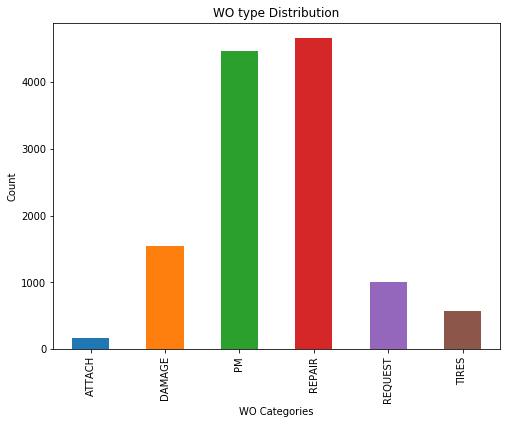

In [10]:
fig = plt.figure(figsize=(8,6))
df_short.groupby('CAT')["Service Description"].count().plot.bar(ylim=0)
plt.xlabel('WO Categories')
plt.ylabel('Count')
plt.title('WO type Distribution')
plt.show()

In [11]:
# It is good practice to represent category as integer rather than string

df_short['CAT_ID']= df_short.CAT.astype('category').cat.codes
df_short.head(10)
df_short.columns
df_short.CAT.astype('category')

0         DAMAGE
1             PM
2             PM
3             PM
4             PM
5             PM
6         REPAIR
7         REPAIR
8         REPAIR
9         DAMAGE
10        REPAIR
11            PM
12            PM
13            PM
14            PM
15            PM
16            PM
17        DAMAGE
18            PM
19            PM
20            PM
21            PM
22            PM
23            PM
24        REPAIR
25            PM
26        REPAIR
27        DAMAGE
28        REPAIR
29        REPAIR
          ...   
19455     REPAIR
19456     DAMAGE
19458     REPAIR
19459         PM
19460     REPAIR
19461         PM
19462     REPAIR
19466     DAMAGE
19467         PM
19468         PM
19469     DAMAGE
19472    REQUEST
19473    REQUEST
19475     REPAIR
19476     REPAIR
19477     REPAIR
19478    REQUEST
19479     DAMAGE
19480         PM
19481     REPAIR
19482         PM
19484     REPAIR
19485     REPAIR
19486     REPAIR
19487         PM
19488     DAMAGE
19489     REPAIR
19490     DAMA

In [12]:
# concatinating fields as data input is not standard 

df_short['Text_Paragraph'] = df_short[['desc', 'Complaint','Cause', 'Cure', 'Additioanl']].apply(lambda x: ' '.join(x), axis = 1) 
df_short.head()


,Service Description,CAT,WC,FLS GRP,desc,Complaint,Cause,Cure,Additioanl,CAT_ID,Text_Paragraph
0,svc desc: field servicecomplaint: safety issue...,DAMAGE,UMATILLA,FORKLIFTS,field service,safety issues lights,travel alarm strobe,replace part replace part,back-up alarm needs installation & serial # 60...,1,field service safety issues lights travel alar...
1,svc desc: pm agreementsadditional: planned mai...,PM,3174,FORKLIFTS,pm agreements,,,,planned maintenance,2,pm agreements planned maintenance
2,svc desc: pm agreementscause: planned maintenance,PM,3174,FORKLIFTS,pm agreements,,planned maintenance,,,2,pm agreements planned maintenance
3,svc desc: pm agreements planned maintenance la...,PM,5520,FORKLIFTS,pm agreements planned maintenance labor not bi...,,,,,2,pm agreements planned maintenance labor not bi...
4,svc desc: pm agreements planned maintenance,PM,3174,FORKLIFTS,pm agreements planned maintenance,,,,,2,pm agreements planned maintenance


In [13]:
# data Preprocessing
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    cleantext = re.sub('[^A-Za-z\s]+', '', sentence)
    tokens = word_tokenize(cleantext)  
    filtered_words = [w for w in tokens  if not w  in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(lemma_words)

df_short['Text_Paragraph']=df_short['Text_Paragraph'].map(lambda s:preprocess(s)) 


### TF-idf


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df_short.Text_Paragraph).toarray()
labels = df_short.CAT_ID
features.shape

(12397, 6551)

#### Random Forest


In [15]:
# random forest

# this block is to split the dataset into training and testing set 
X = df_short['Text_Paragraph']
Y = df_short['CAT_ID']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20 , random_state=42, stratify = Y )


# Model training Pipeline
pipeline = Pipeline([('vect', tfidf),
                     ('chi',  SelectKBest(chi2, k=1000)),
                     ('clf', RandomForestClassifier())])

# fitting our model and save it in a pickle for later use
model = pipeline.fit(X_train, y_train)
with open('RandomForest.pickle', 'wb') as f:
    pickle.dump(model, f)

ytest = np.array(y_test)

# confusion matrix and classification report(precision, recall, F1-score)
print(confusion_matrix(ytest, model.predict(X_test)))
print(classification_report(ytest, model.predict(X_test)))
print("accuracy score: " + str(model.score(X_test, y_test)))


C:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[[ 14   1   0  17   0   0]
 [  2 264   0  36   5   1]
 [  0   1 880  12   1   0]
 [  2  19  23 878   6   3]
 [  0   4  34  40 123   0]
 [  0   1   3   9   0 101]]
              precision    recall  f1-score   support

           0       0.78      0.44      0.56        32
           1       0.91      0.86      0.88       308
           2       0.94      0.98      0.96       894
           3       0.89      0.94      0.91       931
           4       0.91      0.61      0.73       201
           5       0.96      0.89      0.92       114

   micro avg       0.91      0.91      0.91      2480
   macro avg       0.90      0.79      0.83      2480
weighted avg       0.91      0.91      0.91      2480

accuracy score: 0.9112903225806451


In [23]:
 print(model.predict([preprocess("fixed problem in attachment")]))

[0]
